In [7]:
!pip install -q gdown

In [8]:
import gdown
import numpy as np
from keras.layers import Input, RandomContrast, RandomContrast, RandomTranslation,Flatten,Dropout
from keras.layers import Dense, Conv2D, Activation, MaxPooling2D, Rescaling, GlobalMaxPooling2D
from tensorflow.python.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import tensorflow as tf
from pathlib import Path
from typing import Tuple, Any
import keras
from keras import layers
import cv2
#from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import os
import random

2024-07-08 14:12:30.436550: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-08 14:12:30.436659: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-08 14:12:30.598507: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [9]:

# TP1-3-natural-scenes.zip
gdown.download('https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ')

Downloading...
From (original): https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ
From (redirected): https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ&confirm=t&uuid=2d674ba9-29df-49a4-b661-b74e870d0a78
To: /kaggle/working/TP1-3-natural-scenes.zip
100%|██████████| 363M/363M [00:01<00:00, 197MB/s]  


'TP1-3-natural-scenes.zip'

In [10]:
import zipfile

with zipfile.ZipFile('TP1-3-natural-scenes.zip', 'r') as zip_ref:
    zip_ref.extractall('./TP1-3')

In [11]:
   gpus = tf.config.experimental.list_physical_devices("GPU")
   if gpus:
    try:
      for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu,True)
      logical_gpus=tf.config.experimental.list_logical_devices("GPU")
    except RuntimeError as e:
      print(e)

In [12]:
TRAIN_DATA_FOLDER = Path("/kaggle/working/TP1-3/seg_train/seg_train")
VAL_DATA_FOLDER = Path("/kaggle/working/TP1-3/seg_test/seg_test")
TEST_DATA_FOLDER = Path("/kaggle/working/TP1-3/seg_pred/seg_pred")

BATCH_SIZE=32
IMG_H = 256
IMG_W = 256

In [13]:
train_dataset=tf.keras.utils.image_dataset_from_directory(
    TRAIN_DATA_FOLDER,
    label_mode="categorical",
    image_size=(IMG_H,IMG_W),
    batch_size=BATCH_SIZE
)

val_dataset=tf.keras.utils.image_dataset_from_directory(
    VAL_DATA_FOLDER,
    label_mode="categorical",
    image_size=(IMG_H,IMG_W),
    batch_size=BATCH_SIZE
)



Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


In [10]:
count_dataset_classes=tf.keras.utils.image_dataset_from_directory(
    TRAIN_DATA_FOLDER,
    label_mode="categorical",
    image_size=(IMG_H,IMG_W),
    batch_size=1  #1 porque debemos contar las imagenes
)

Found 14034 files belonging to 6 classes.


In [15]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random

def procesar_imagen_prediccion(path: str) -> np.array:
    imagen = cv2.imread(path)
    imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
    imagen_redimensionada = cv2.resize(imagen, (256, 256))
    imagen_para_prediccion = np.expand_dims(imagen_redimensionada, axis=0)

    return imagen_para_prediccion

def predecir_clase(path: str, modelo: tf.keras.Model) -> str:
    imagen_para_prediccion = procesar_imagen_prediccion(path)
    predicciones = modelo.predict(imagen_para_prediccion)
    
    clases = train_dataset.class_names
    diccionario_etiquetas = {i: clase for i, clase in enumerate(clases)}

    indice_clase_max_probabilidad = np.argmax(predicciones, axis=1)
    etiqueta_predicha = diccionario_etiquetas[indice_clase_max_probabilidad[0]]

    return etiqueta_predicha, predicciones

def predecir_y_mostrar_10_imagenes(folder_path: str, modelo: tf.keras.Model) -> Any:
    fig, axs = plt.subplots(2, 5, figsize=(20, 8))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    axs = axs.ravel()

    random_images = random.sample(os.listdir(folder_path), 10)

    for i, image_name in enumerate(random_images):
        image_path = os.path.join(folder_path, image_name)
        imagen_predicha, predicciones = predecir_clase(image_path, modelo)
        imagen = cv2.imread(image_path)
        imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)

        axs[i].imshow(imagen)
        axs[i].set_title(f"Predicción: {imagen_predicha}")
        axs[i].axis('off')

    plt.show()



Found 14034 files belonging to 6 classes.


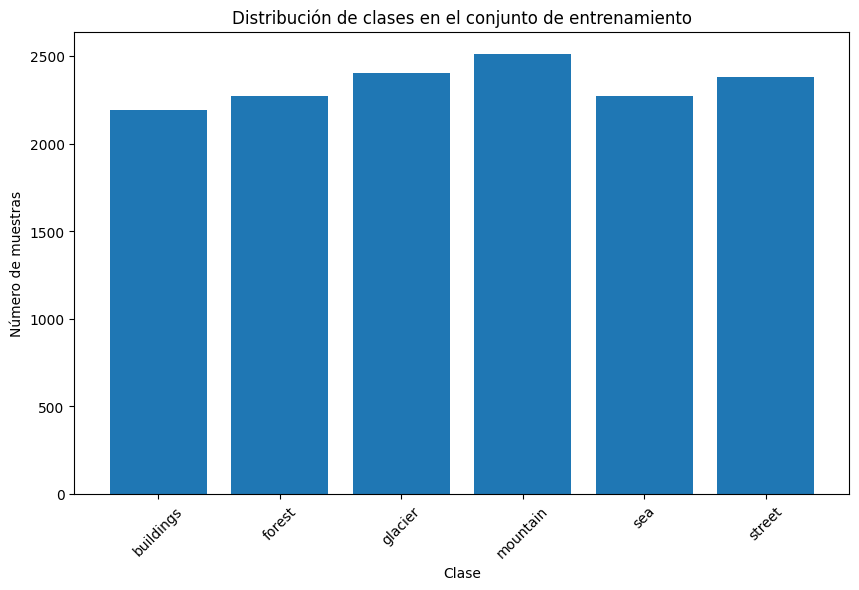

In [16]:
# Crear el dataset desde el directorio
count_dataset_classes = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DATA_FOLDER,
    label_mode="categorical",
    image_size=(IMG_H, IMG_W),
    batch_size=1  # 1 porque debemos contar las imágenes una por una
)

# Obtener las etiquetas de las clases
class_names = count_dataset_classes.class_names

# Inicializar un diccionario para contar las muestras en cada clase
class_counts = {class_name: 0 for class_name in class_names}

# Contar las muestras en cada clase
for images, labels in count_dataset_classes:
    label_index = tf.argmax(labels, axis=1).numpy()[0]  # Obtener el índice de la clase
    class_counts[class_names[label_index]] += 1

# Visualizar la distribución de clases
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.title('Distribución de clases en el conjunto de entrenamiento')
plt.xlabel('Clase')
plt.ylabel('Número de muestras')
plt.xticks(rotation=45)
plt.show()


In [18]:
def plot_training_history(history) -> plt:
    # Accuracy
    plt.plot(history.history['accuracy'], label='train accuracy')
    plt.plot(history.history['val_accuracy'], label='validation accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Pérdida
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='validation loss')
    plt.title('Pérdida')
    plt.xlabel('Epoch')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.show()


In [14]:
EARLY_STOPPING = EarlyStopping(
    monitor='val_loss',
    patience=20,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

REDUCE_LR = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    verbose=1,
    mode='min',
    min_delta=1e-4,
    cooldown=0,
    min_lr=1e-6
)

Cantidad de clases en el dataset

In [19]:
len(train_dataset.class_names)

6

In [20]:
train_dataset.class_names

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

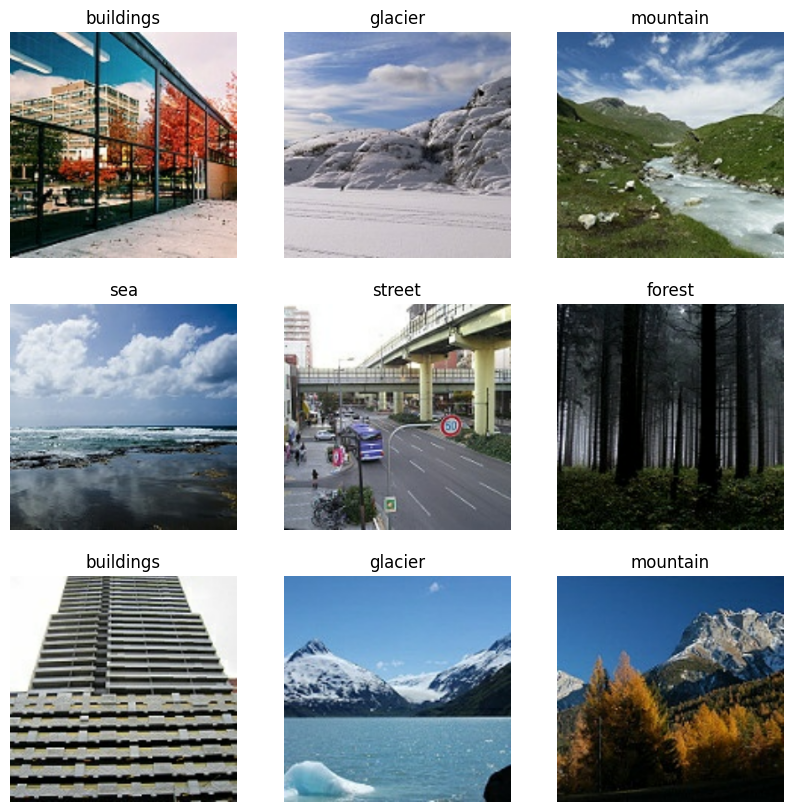

In [21]:
plt.figure(figsize=(10,10))
for images,labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    class_idx = list(labels[i]).index(1)
    plt.title(train_dataset.class_names[class_idx])
    plt.axis("off")


##Modelo de capas densas

In [37]:
def dense_model(input_shape, output_label: int) -> tf.keras.Model:
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=input_shape), #escalar entrada que vaya de 0 a 1
        tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.Dense(units=32, activation="sigmoid"),
        tf.keras.layers.Dense(units=64, activation="relu"),
        tf.keras.layers.Dense(units=8, activation="sigmoid"),
        tf.keras.layers.Dense(units=output_label, activation="softmax")
    ])
    return model


In [38]:
dense_model=dense_model(input_shape=(IMG_H,IMG_W,3),output_label=6)
dense_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 196608)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 196608)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │     6,291,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 6)              │            54 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,294,174 (24.01 MB)

 Trainable params: 6,294,174 (24.01 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
dense_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [40]:
history_dense_model = dense_model.fit(
    train_dataset,
    validation_data=val_dataset,  # Datos de validación
    epochs=50,
    batch_size=BATCH_SIZE,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
    ]
)

Epoch 1/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.1669 - loss: 1.8191 - val_accuracy: 0.1750 - val_loss: 1.7923 - learning_rate: 0.0010
Epoch 2/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.1755 - loss: 1.7916 - val_accuracy: 0.1750 - val_loss: 1.7908 - learning_rate: 0.0010
Epoch 3/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.1811 - loss: 1.7913 - val_accuracy: 0.1750 - val_loss: 1.7915 - learning_rate: 0.0010
Epoch 4/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.1807 - loss: 1.7913 - val_accuracy: 0.1750 - val_loss: 1.7908 - learning_rate: 0.0010
Epoch 5/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.1826 - loss: 1.7911 - val_accuracy: 0.1750 - val_loss: 1.7913 - learning_rate: 0.0010
Epoch 6/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.1831 - loss: 1.7908 - val_accuracy: 0.1750 - val_loss: 1.7904 - learning_rate: 0.0010
Epoch 7/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.1817 - loss: 

In [41]:
print("Evaluate on test data")
results = dense_model.evaluate(val_dataset, batch_size=BATCH_SIZE)
print("test loss, test acc:", results)

Evaluate on test data
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.1726 - loss: 1.7895
test loss, test acc: [1.789966344833374, 0.17499999701976776]


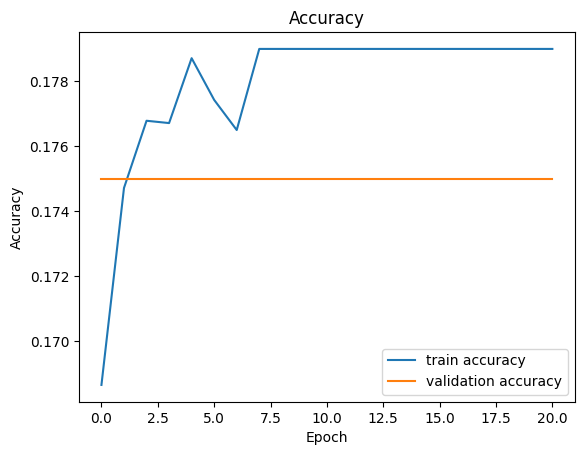

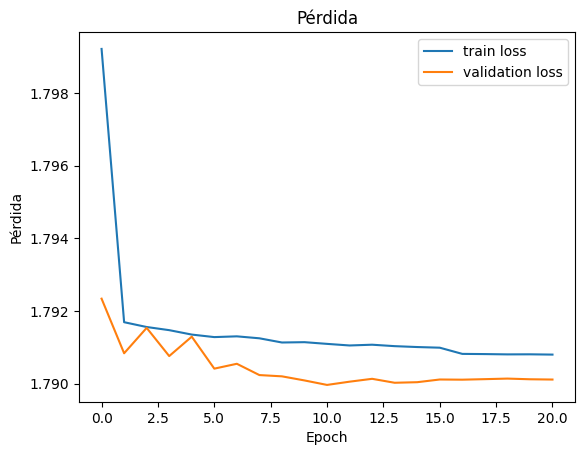

In [42]:
plot_training_history(history_dense_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


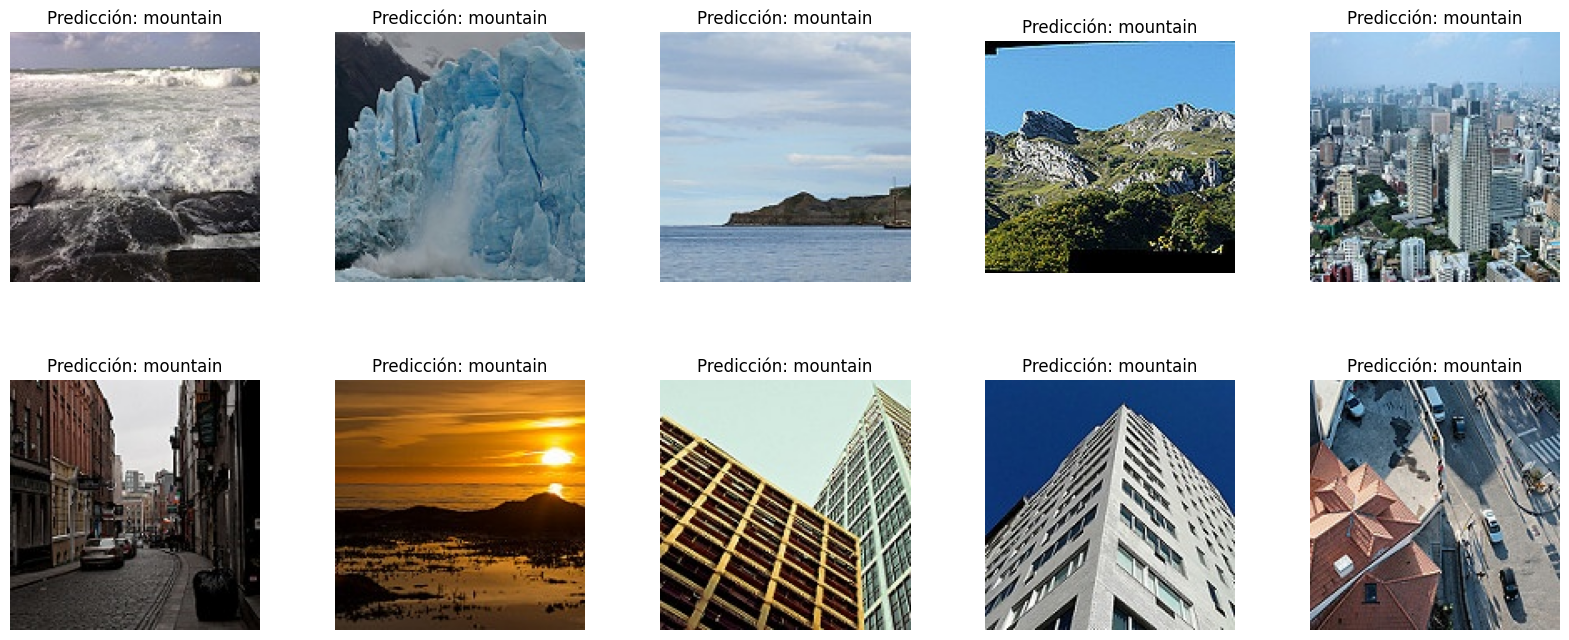

In [44]:
predecir_y_mostrar_10_imagenes("/kaggle/working/TP1-3/seg_pred/seg_pred",dense_model)

## Modelo con capas convolucionales y densas.


In [22]:
def cnn_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Rescaling(1./255),

        tf.keras.layers.Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(0.01)),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.01)),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.01)),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [23]:
model_cnn = cnn_model(input_shape=(IMG_H, IMG_W, 3), num_classes=len(train_dataset.class_names))
model_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    33,554,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,649,478 (128.36 MB)

 Trainable params: 33,649,478 (128.36 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
model_cnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [25]:
history_cnn=model_cnn.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    batch_size=BATCH_SIZE,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
    ]
)


Epoch 1/50


2024-07-08 14:14:20.596203: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.99935, expected 2.28267
2024-07-08 14:14:20.596270: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 4.17207, expected 3.45539
2024-07-08 14:14:20.596279: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 4.3619, expected 3.64522
2024-07-08 14:14:20.596287: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 5.47131, expected 4.75463
2024-07-08 14:14:20.596295: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 5.50046, expected 4.78378
2024-07-08 14:14:20.596326: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 5.73262, expected 5.01594
2024-07-08 14:14:20.596338: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 4.78622, expected 4.06954
2024-07-08 14:14:20.596347: E external/local_xla/xla/ser

  5/439 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - accuracy: 0.1353 - loss: 13.0598 

I0000 00:00:1720448070.455642     113 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


437/439 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3559 - loss: 5.9799

2024-07-08 14:14:47.056736: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.85026, expected 1.89179
2024-07-08 14:14:47.056813: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 5.22064, expected 4.26218
2024-07-08 14:14:47.056823: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 4.91759, expected 3.95912
2024-07-08 14:14:47.056831: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 5.33446, expected 4.37599
2024-07-08 14:14:47.056839: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 6.71557, expected 5.7571
2024-07-08 14:14:47.056847: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 6.3152, expected 5.35673
2024-07-08 14:14:47.056855: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 5.93033, expected 4.97187
2024-07-08 14:14:47.056863: E external/local_xla/xla/serv

439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.3562 - loss: 5.9686

2024-07-08 14:15:00.478846: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.35121, expected 2.40063
2024-07-08 14:15:00.478905: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 4.59262, expected 3.64204
2024-07-08 14:15:00.478915: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 4.90437, expected 3.95378
2024-07-08 14:15:00.478923: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.07336, expected 5.12277
2024-07-08 14:15:00.478931: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 6.68734, expected 5.73676
2024-07-08 14:15:00.478939: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 6.9172, expected 5.96662
2024-07-08 14:15:00.478946: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.64532, expected 5.69474
2024-07-08 14:15:00.478954: E external/local_xla/xla/ser

439/439 ━━━━━━━━━━━━━━━━━━━━ 47s 75ms/step - accuracy: 0.3563 - loss: 5.9629 - val_accuracy: 0.5593 - val_loss: 1.8135 - learning_rate: 0.0010
Epoch 2/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - accuracy: 0.5344 - loss: 1.9757 - val_accuracy: 0.5793 - val_loss: 1.7390 - learning_rate: 0.0010
Epoch 3/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - accuracy: 0.5635 - loss: 1.7343 - val_accuracy: 0.5753 - val_loss: 1.5562 - learning_rate: 0.0010
Epoch 4/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - accuracy: 0.5743 - loss: 1.5996 - val_accuracy: 0.6167 - val_loss: 1.5508 - learning_rate: 0.0010
Epoch 5/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - accuracy: 0.5843 - loss: 1.5845 - val_accuracy: 0.6230 - val_loss: 1.3533 - learning_rate: 0.0010
Epoch 6/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - accuracy: 0.5859 - loss: 1.5937 - val_accuracy: 0.5977 - val_loss: 1.3929 - learning_rate: 0.0010
Epoch 7/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - accuracy: 0.5866 - loss: 1.5835

In [27]:
print("Evaluate on test data")
results = model_cnn.evaluate(val_dataset, batch_size=BATCH_SIZE)
print("test loss, test acc:", results)

Evaluate on test data
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7314 - loss: 0.9000
test loss, test acc: [0.899552583694458, 0.7296666502952576]


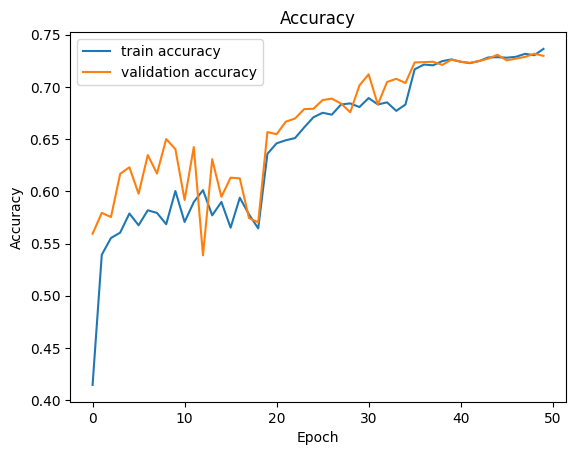

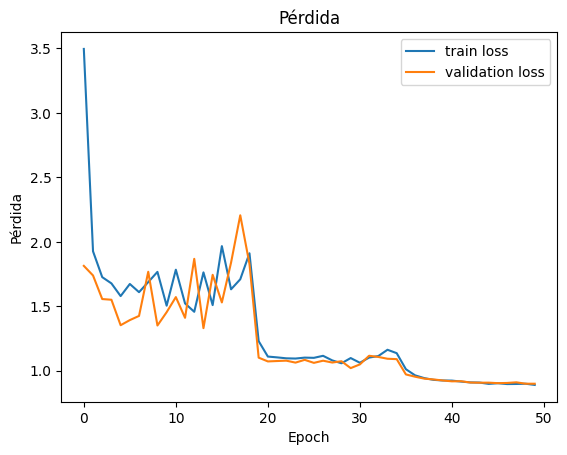

In [28]:
plot_training_history(history_cnn)

2024-07-08 14:29:53.275717: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65536: 3.21834, expected 2.7814
2024-07-08 14:29:53.275782: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65568: 3.26727, expected 2.83033
2024-07-08 14:29:53.275793: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65715: 3.18355, expected 2.74662
2024-07-08 14:29:53.277387: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 393216: 3.19018, expected 2.45051
2024-07-08 14:29:53.277418: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 393217: 5.27948, expected 4.5398
2024-07-08 14:29:53.277427: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 393218: 5.16353, expected 4.42385
2024-07-08 14:29:53.277435: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 393219: 5.87278, expected 5.1331
2024-07-08 14:29:53.277443

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


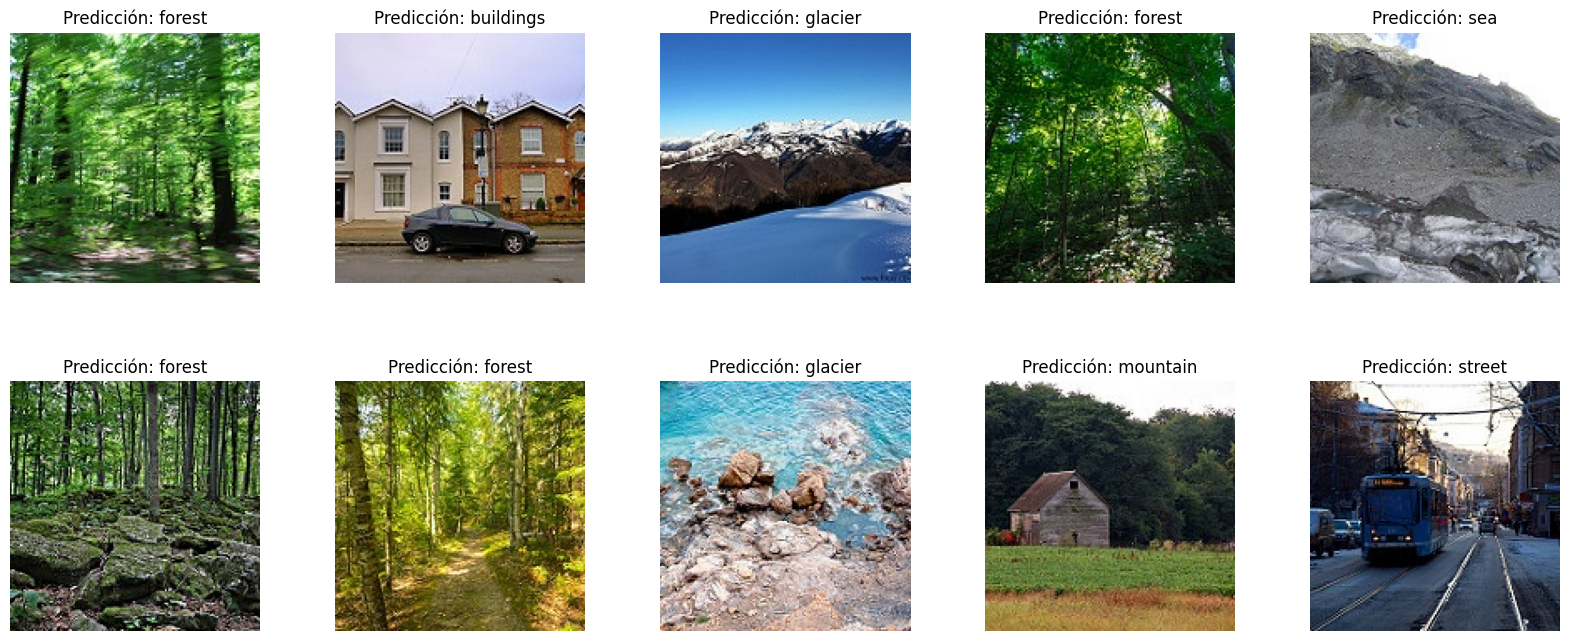

In [30]:
predecir_y_mostrar_10_imagenes("/kaggle/working/TP1-3/seg_pred/seg_pred",model_cnn)

## Modelo que incluya bloques residuales identidad:


In [14]:
def identity_block(input_tensor, kernel_size, filters):
    filters1, filters2, filters3 = filters

    x = tf.keras.layers.Conv2D(filters1, (1, 1))(input_tensor)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(filters2, kernel_size, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(filters3, (1, 1))(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.add([x, input_tensor])
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [17]:
def cnn_model_with_res_blocks(*, input_shape, labels):
    input_tensor = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.Rescaling(1./255)(input_tensor)

    x = tf.keras.layers.Conv2D(16, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = identity_block(x, (3, 3), [16, 16, 16])
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Dropout(0.3)(x)  # Incrementando el dropout para regularización

    x = tf.keras.layers.Conv2D(32, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = identity_block(x, (3, 3), [32, 32, 32])
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = identity_block(x, (3, 3), [64, 64, 64])
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = identity_block(x, (3, 3), [128, 128, 128])
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5)(x)  # Mayor dropout en la capa densa
    x = tf.keras.layers.Dense(labels, activation='softmax')(x)

    model = tf.keras.Model(inputs=input_tensor, outputs=x)
    return model


In [18]:
cnn_model_res=cnn_model_with_res_blocks(input_shape=(IMG_H,IMG_W,3),labels=len(train_dataset.class_names))
cnn_model_res.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 256, 256,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │        272 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │      2,320 │ activation[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │        272 │ activation_1[0][… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 16)               │            │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 256, 256,  │          0 │ add[0][0]         │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ max_pooling2d[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │      4,640 │ dropout[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │      1,056 │ conv2d_4[0][0]  

 Total params: 8,730,806 (33.31 MB)

 Trainable params: 8,729,366 (33.30 MB)

 Non-trainable params: 1,440 (5.62 KB)

In [19]:
cnn_model_res.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [20]:
history_cnn_model_res=cnn_model_res.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    batch_size=BATCH_SIZE,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
    ]
)

Epoch 1/50


2024-07-08 12:17:49.566793: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.96116, expected 2.28267
2024-07-08 12:17:49.566855: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 4.13388, expected 3.45539
2024-07-08 12:17:49.566869: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 4.32371, expected 3.64522
2024-07-08 12:17:49.566883: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 5.43312, expected 4.75463
2024-07-08 12:17:49.566900: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 5.46228, expected 4.78378
2024-07-08 12:17:49.566912: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 5.69444, expected 5.01594
2024-07-08 12:17:49.566924: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 4.74803, expected 4.06954
2024-07-08 12:17:49.566936: E external/local_xla/xla/se

  2/439 ━━━━━━━━━━━━━━━━━━━━ 38s 89ms/step - accuracy: 0.1094 - loss: 46.3037   

I0000 00:00:1720441090.126027     125 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


438/439 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.4420 - loss: 10.1765

2024-07-08 12:18:46.914082: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.85903, expected 1.89179
2024-07-08 12:18:46.914153: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 5.22941, expected 4.26218
2024-07-08 12:18:46.914163: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 4.92636, expected 3.95912
2024-07-08 12:18:46.914171: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 5.34323, expected 4.37599
2024-07-08 12:18:46.914179: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 6.72434, expected 5.7571
2024-07-08 12:18:46.914187: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 6.32397, expected 5.35673
2024-07-08 12:18:46.914194: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 5.9391, expected 4.97187
2024-07-08 12:18:46.914202: E external/local_xla/xla/serv

439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.4422 - loss: 10.1663

2024-07-08 12:19:06.373501: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65536: 3.16688, expected 2.50527
2024-07-08 12:19:06.373574: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65537: 3.74959, expected 3.08798
2024-07-08 12:19:06.373596: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65538: 4.88824, expected 4.22663
2024-07-08 12:19:06.373611: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65540: 5.59849, expected 4.93688
2024-07-08 12:19:06.373622: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65544: 4.50976, expected 3.84815
2024-07-08 12:19:06.373634: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65545: 5.53352, expected 4.87191
2024-07-08 12:19:06.373645: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65546: 5.01042, expected 4.34881
2024-07-08 12:19:06.373656:

439/439 ━━━━━━━━━━━━━━━━━━━━ 95s 137ms/step - accuracy: 0.4425 - loss: 10.1562 - val_accuracy: 0.1833 - val_loss: 4.6265 - learning_rate: 0.0010
Epoch 2/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 34s 77ms/step - accuracy: 0.6521 - loss: 2.4701 - val_accuracy: 0.6537 - val_loss: 1.8822 - learning_rate: 0.0010
Epoch 3/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 34s 77ms/step - accuracy: 0.6950 - loss: 1.6551 - val_accuracy: 0.5490 - val_loss: 2.2433 - learning_rate: 0.0010
Epoch 4/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 34s 77ms/step - accuracy: 0.7275 - loss: 1.3273 - val_accuracy: 0.5333 - val_loss: 2.0155 - learning_rate: 0.0010
Epoch 5/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 34s 77ms/step - accuracy: 0.7485 - loss: 1.1309 - val_accuracy: 0.7667 - val_loss: 1.0081 - learning_rate: 0.0010
Epoch 6/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 34s 77ms/step - accuracy: 0.7730 - loss: 1.0263 - val_accuracy: 0.6907 - val_loss: 1.1592 - learning_rate: 0.0010
Epoch 7/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 34s 77ms/step - accuracy: 0.7754 - loss: 1.03

In [21]:
print("Evaluate on test data")
results = cnn_model_res.evaluate(val_dataset, batch_size=BATCH_SIZE)
print("test loss, test acc:", results)

Evaluate on test data
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8811 - loss: 0.4801
test loss, test acc: [0.47838088870048523, 0.878333330154419]


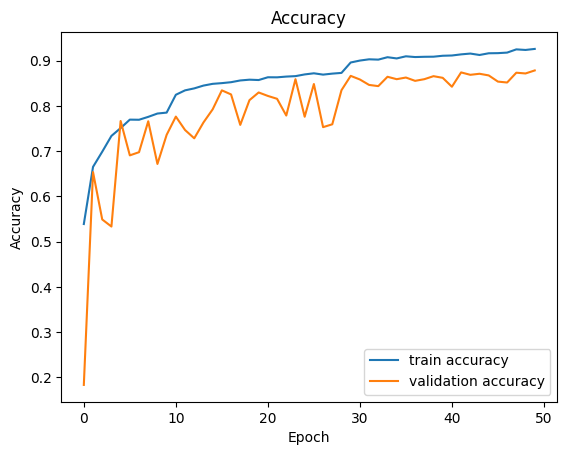

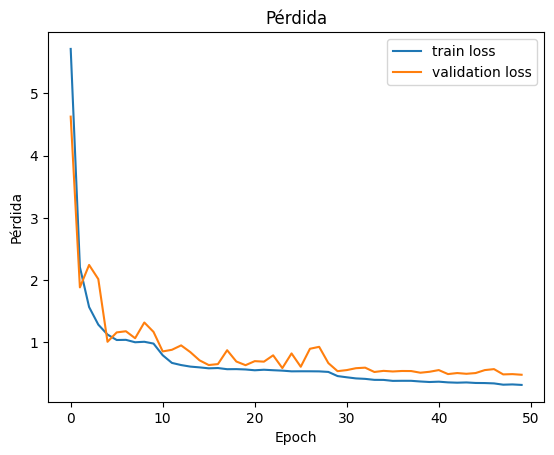

In [22]:
plot_training_history(history_cnn_model_res)

2024-07-08 12:48:23.995127: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65536: 3.46471, expected 2.7814
2024-07-08 12:48:23.995184: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65537: 5.03943, expected 4.35612
2024-07-08 12:48:23.995194: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65538: 5.38665, expected 4.70334
2024-07-08 12:48:23.995202: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65544: 5.56278, expected 4.87948
2024-07-08 12:48:23.995210: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65545: 5.43827, expected 4.75496
2024-07-08 12:48:23.995218: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65546: 5.45952, expected 4.77621
2024-07-08 12:48:23.995226: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65547: 5.01216, expected 4.32885
2024-07-08 12:48:23.995234: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


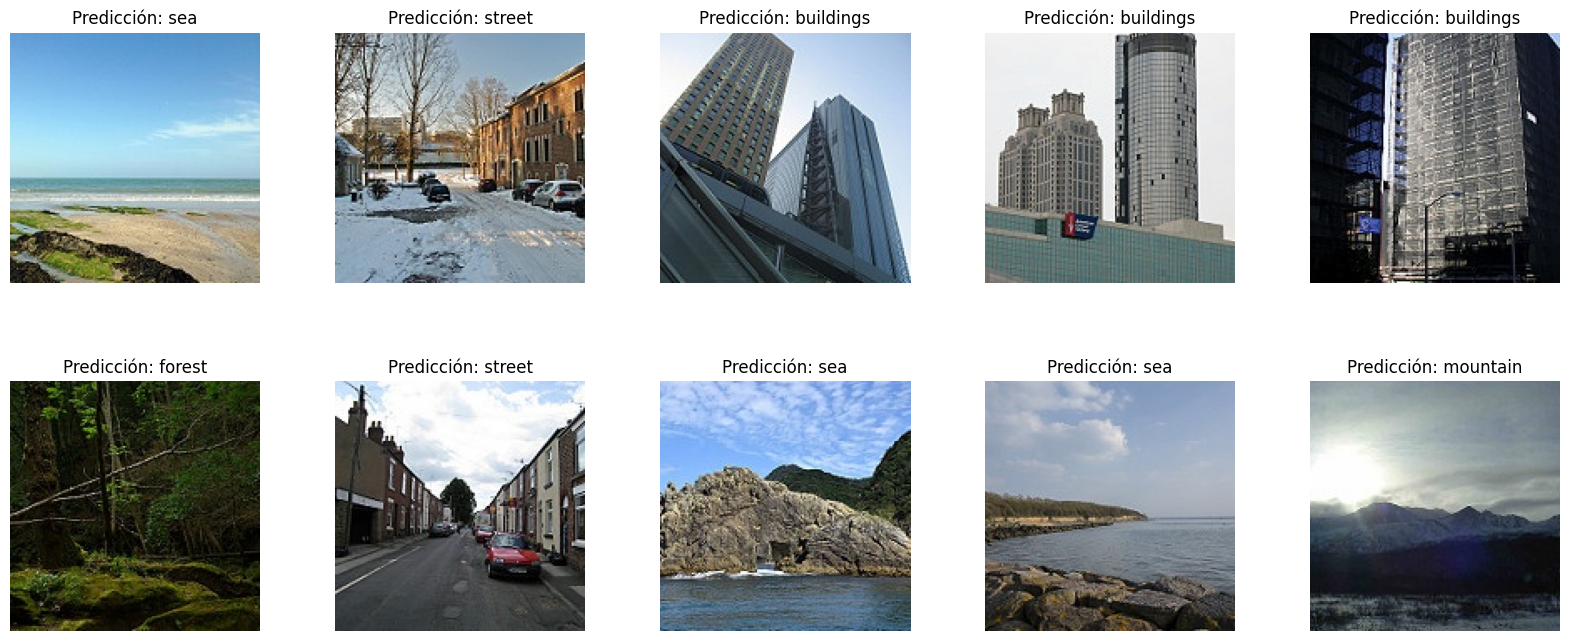

In [23]:
predecir_y_mostrar_10_imagenes("/kaggle/working/TP1-3/seg_pred/seg_pred",cnn_model_res)

## Modelo Transfer Learning

In [25]:
train_dataset=tf.keras.utils.image_dataset_from_directory(
    str(TRAIN_DATA_FOLDER),
    label_mode="categorical",
    image_size=(224, 224), #probar con 224 o menos
    batch_size=BATCH_SIZE
)

val_dataset=tf.keras.utils.image_dataset_from_directory(
    str(VAL_DATA_FOLDER),
    label_mode="categorical",
    image_size=(224, 224), #probar 224
    batch_size=BATCH_SIZE
)


Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


In [26]:
def transfered_learning_model(input_shape: Tuple[int], num_classes: int) -> tf.keras.Model:
    base_model = tf.keras.applications.EfficientNetB0(input_shape=input_shape,
                                                      include_top=False,
                                                      weights='imagenet')
    base_model.trainable = False

    i = Input(shape=input_shape)
    x = base_model(i, training=False)
    x = GlobalMaxPooling2D()(x)
    x = Dropout(0.5)(x)  # Adding dropout
    x = Dense(num_classes, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)  # L2 regularization

    return tf.keras.Model(i, x)

In [27]:
tlm=transfered_learning_model(input_shape=(224,224,3),num_classes=6)
tlm.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 1280)           │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,057,257 (15.48 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [30]:
tlm.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy'])

In [31]:
history_tlm = tlm.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    batch_size=BATCH_SIZE,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
    ]
)


Epoch 1/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 82s 110ms/step - accuracy: 0.6159 - loss: 1.9995 - val_accuracy: 0.8643 - val_loss: 0.5854 - learning_rate: 0.0010
Epoch 2/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - accuracy: 0.8222 - loss: 0.7810 - val_accuracy: 0.8763 - val_loss: 0.5386 - learning_rate: 0.0010
Epoch 3/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - accuracy: 0.8357 - loss: 0.6706 - val_accuracy: 0.8813 - val_loss: 0.4658 - learning_rate: 0.0010
Epoch 4/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - accuracy: 0.8474 - loss: 0.6008 - val_accuracy: 0.8843 - val_loss: 0.4298 - learning_rate: 0.0010
Epoch 5/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - accuracy: 0.8451 - loss: 0.5973 - val_accuracy: 0.8857 - val_loss: 0.3981 - learning_rate: 0.0010
Epoch 6/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - accuracy: 0.8482 - loss: 0.5698 - val_accuracy: 0.8770 - val_loss: 0.4329 - learning_rate: 0.0010
Epoch 7/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - accuracy: 0.8516 - 

In [32]:
print("Evaluate on test data")
results = tlm.evaluate(val_dataset, batch_size=BATCH_SIZE)
print("test loss, test acc:", results)

Evaluate on test data
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9043 - loss: 0.2589
test loss, test acc: [0.2814806401729584, 0.8986666798591614]


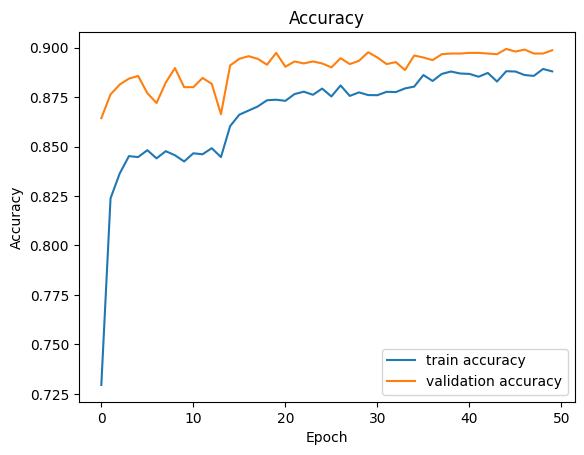

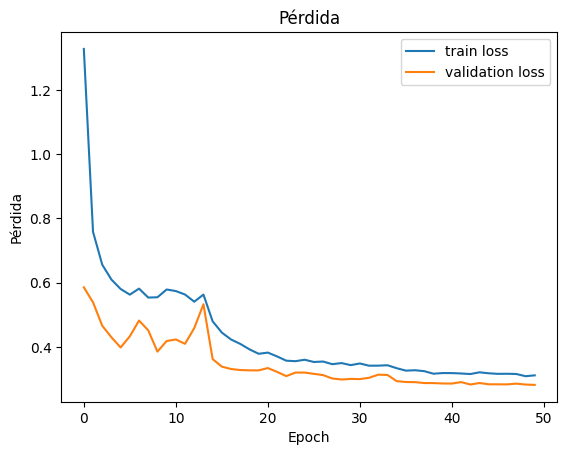

In [33]:
plot_training_history(history_tlm)

In [34]:
def procesar_imagen_prediccion_2(path: str) -> np.array:
    imagen = cv2.imread(path)
    imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
    imagen_redimensionada = cv2.resize(imagen, (224, 224))
    imagen_para_prediccion = np.expand_dims(imagen_redimensionada, axis=0)

    return imagen_para_prediccion

def predecir_clase_2(path: str, modelo: tf.keras.Model) -> str:
    imagen_para_prediccion = procesar_imagen_prediccion_2(path)
    predicciones = modelo.predict(imagen_para_prediccion)

    clases = train_dataset.class_names
    diccionario_etiquetas = {0: clases[0], 1: clases[1], 2: clases[2], 3: clases[3], 4: clases[4], 5: clases[5]}

    indice_clase_max_probabilidad = np.argmax(predicciones, axis=1)
    etiqueta_predicha = diccionario_etiquetas[indice_clase_max_probabilidad[0]]

    return etiqueta_predicha, predicciones

def predecir_y_mostrar_10_imagenes_2(folder_path: str, modelo: tf.keras.Model) -> Any:
    fig, axs = plt.subplots(2, 5, figsize=(20, 8))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    axs = axs.ravel()

    random_images = random.sample(os.listdir(folder_path), 10)

    for i, image_name in enumerate(random_images):
        image_path = os.path.join(folder_path, image_name)
        imagen_predicha, predicciones = predecir_clase_2(image_path, modelo)
        imagen = cv2.imread(image_path)
        imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)

        axs[i].imshow(imagen)
        axs[i].set_title(f"Predicción: {imagen_predicha}")
        axs[i].axis('off')

    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


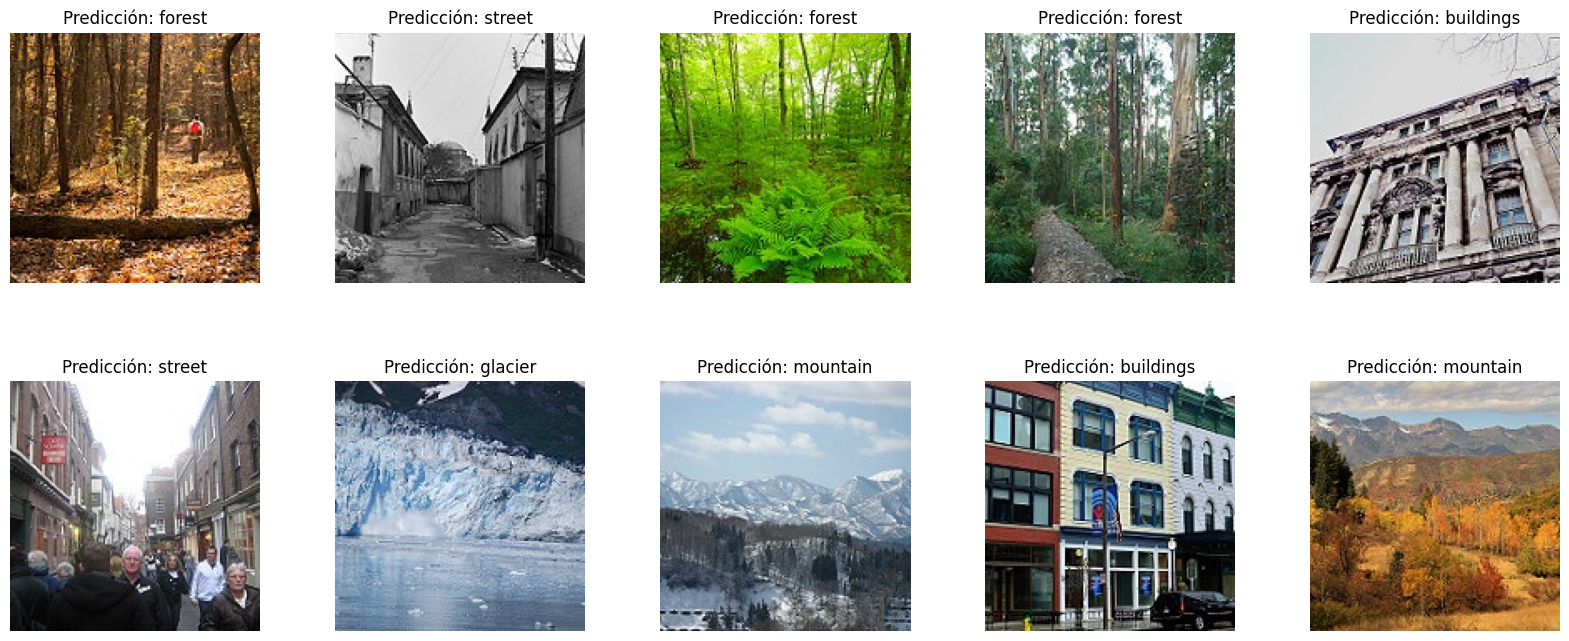

In [36]:
predecir_y_mostrar_10_imagenes_2("/kaggle/working/TP1-3/seg_pred/seg_pred",tlm)